In [1]:
# <!--------------------------------------------------------------------------->
# <!--                    KU - University of Copenhagen                      -->
# <!--                          Faculty of Science                           -->
# <!--                Vision and Image Processing (VIP) Course               -->
# <!-- File       : main.ipynb                                               -->
# <!-- Description: Feature matching and image stitching                     -->
# <!-- Author     : Wengguang Zheng, Weisi Li                                -->
# <!--------------------------------------------------------------------------->

__version__ = "$Revision: 2020010401 $"


In [2]:
import numpy as np  
import matplotlib.pyplot as plt  
import cv2
from sklearn.preprocessing import StandardScaler
import random

In [4]:
def get_harris_position(img,blockSize = 100,aperture_size = 9,k=0.04,threshold = 0.01):
    dst = cv2.cornerHarris(img,blockSize,aperture_size,k)
    dst = cv2.dilate(dst,None)
    ret, dst = cv2.threshold(dst,threshold*dst.max(),255,0)
    dst = np.uint8(dst)

    #find centroids
    ret, labels, stats, centroids = cv2.connectedComponentsWithStats(dst)

    #define the criteria to stop and refine the corners
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.001)
    corners = cv2.cornerSubPix(img,np.float32(centroids),(5,5),(-1,-1),criteria)
    #here u can get corners
    return corners

def show_corner(img,corners):
    fig, ax = plt.subplots()  # show corners
    ax.imshow(img, cmap=plt.cm.gray)
    ax.plot(corners[:, 0], corners[:, 1], '.b', markersize=8)
    plt.title('Harris Detection')
    plt.show()


In [5]:
# to calculate single patch
def extract_patch(img, corner,n):
    x = int(corner[0]) 
    y = int(corner[1]) 
    size_n = int(n/2)
    # #print(size_n)
    # new_corner = [x,y]
    window = img[(x-size_n):(x+size_n+1), (y-size_n):(y+size_n+1)]
   # print(window)
    return  window 

# to take patches
def get_patch(corners,replicate_img,n,d):
    windows = []
    new_corners = []
    scaler = StandardScaler() 
    for each_corner in corners:
        if each_corner[1] < d[0] or each_corner[1] > d[1] or each_corner[0] < d[2] or each_corner[0] > d[3]:
            continue
        window = extract_patch(replicate_img,each_corner,n)
        
        if len(window)>0 and window.shape == (n,n):
            window = scaler.fit_transform(window) 
            # window = sklearn.preprocessing.normalize(window)
            windows.append(window)
            new_corners.append(each_corner)
    return windows,new_corners


In [6]:
# to calculate SSD and apply ratio to calculate the first_match
def ssd(p1,p2,new_corners1,new_corners2,r=0.8):
    match = []
    locations_A = []
    locations_B = []
    for each_p1,each_location1 in zip(p1,new_corners1):
        similarity1 = [999,0]
        similarity2 = [999,0]
        for i, (each_p2,each_location2) in enumerate(zip(p2,new_corners2)):
            p1_sub_p2 = np.subtract(each_p1,each_p2)
            p1p2square = np.power(p1_sub_p2,2)
            score = np.power(np.sum(p1p2square),0.5)

            if score < similarity1[0]:
                similarity1 = [score,i]
            elif score < similarity2[0]:
                similarity2 = [score,i]

        if similarity1[0] < r * similarity2[0]:
        	match.append([each_p1,p2[similarity1[1]]])
        	locations_A.append(each_location1)
        	locations_B.append(new_corners2[similarity1[1]])
        	
    return match,locations_A,locations_B

def ssdstat(matches):
    totals = []
    for each_array1 in matches:
        total = np.subtract(each_array1[0:1], each_array1[1:2])
        total = np.power(total, 2)
        total = np.power(np.sum(total), 0.5)
        totals.append(total)
    return totals


In [7]:
def eliminateMultiCorrespondence(locations_A,locations_B,locations_2A,locations_2B):
    match_locationsA = []
    match_locationsB = []

    for l_A,l_B in zip(locations_A,locations_B):
        for l_2A,l_2B in zip(locations_2A,locations_2B):
            if l_A.tolist() == l_2A.tolist() and l_B.tolist() == l_2B.tolist():
                match_locationsA.append(l_A)
                match_locationsB.append(l_B)

    return match_locationsA, match_locationsB


In [8]:
def to_kpt(pt,size=1):
	return cv2.KeyPoint(pt[0],pt[1],size)

def stitch_imgs(img1, img2):
    """
    img1 and img2 can be the same
    """
    double_img = np.concatenate((img1, img2), axis = 1)
    return double_img 

In [9]:
def draw_lines(img, list_of_a_coords, list_of_b_coords, color = (0,255,0), thickness = 5):
    width = int(img.shape[1]/2)
    for A_coord, B_coord in zip(list_of_a_coords, list_of_b_coords):
        cv2.circle(img, (int(A_coord[0]),int(A_coord[1])),50,(255,0,0),7)
        cv2.circle(img, (int(B_coord[0]+width),int(B_coord[1])),50,(255,0,0),7)
        cv2.line(img, (int(A_coord[0]),int(A_coord[1])),((int(B_coord[0])+width),int(B_coord[1])),color,thickness)
    return img

In [10]:
def constructA(l,r):
    result = []
    for i in range(l.shape[0]):
        xl = l[i,0,0]
        yl = l[i,0,1]
        xr = r[i,0,0]
        yr = r[i,0,1]
        result.append([-xl,-yl,-1,0,0,0,xl*xr,yl*xr,xr])
        result.append([0,0,0,-xl,-yl,-1,xl*yr,yl*yr,yr])
    return np.array(result)

def computeH(dst_pts,src_pts):
    A = constructA(dst_pts,src_pts)
    U, s, V = np.linalg.svd(A)
    H = V[:,-1]
    H =H.reshape(3,3)/H[-1]
    return H

In [11]:
# MAIN
#============== LOAD ================#
img1_origin = cv2.imread('./inputs/im1red.png')
img2_origin = cv2.imread('./inputs/im2red.png')

img1 = cv2.cvtColor(img1_origin, cv2.COLOR_BGR2GRAY)
img2 = cv2.cvtColor(img2_origin, cv2.COLOR_BGR2GRAY)

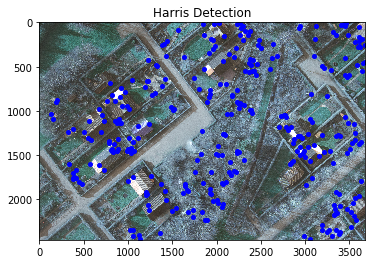

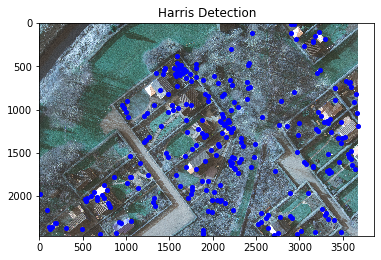

In [12]:
#============== 1.Detecting interest points ==============#
#print(type(img1),img1,np.shape(img1))
corners1 = get_harris_position(img1,blockSize=20,aperture_size=7,k=0.01,threshold = 0.1)
corners2 = get_harris_position(img2,blockSize=20,aperture_size=7,k=0.01,threshold = 0.1)

show_corner(img1_origin,corners1)
show_corner(img2_origin,corners2)
#============== 1.Detecting interest points ==============#

In [13]:
#============== 2.Feature matching ==============#
replicate_img1 = cv2.copyMakeBorder(img1,30,30,30,30,cv2.BORDER_REPLICATE)
replicate_img2 = cv2.copyMakeBorder(img2,30,30,30,30,cv2.BORDER_REPLICATE)

#----- 2.1 For each extracted point you attribute a descriptor ------#
# Get windows
# Side length
n = 31 #(the patch size, between 3-31, odd)
# Test it one by one! 
print("The patch size",n)

#--- hint3 ---#
dx = 1300
dy = 100
d1=(0,dx,dy,replicate_img1.shape[1])
patches1,pat_corners1 = get_patch(corners1,replicate_img1,n,d1)
d2=(dx,replicate_img2.shape[0],0,replicate_img2.shape[1]-dy)
patches2,pat_corners2 = get_patch(corners2,replicate_img2,n,d2)

n/utils/validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversio

In [14]:
#----- 2.2 select matches as the pair of interest points that have most similar descriptors ----#

#(the ratio between best match and the second match)
# for r in [0.95,0.9,0.85,0.8,0.75,0.7,0.65,0.6]:
# Test it one by one! 
#--- hint1 ---#
r = 0.99
print("Ratio",r)
match_AtoB,locations_A,locations_B= ssd(patches1,patches2,pat_corners1,pat_corners2,r)
match_BtoA,locations_2B,locations_2A= ssd(patches2,patches1,pat_corners2,pat_corners1,r)

Ratio 0.99


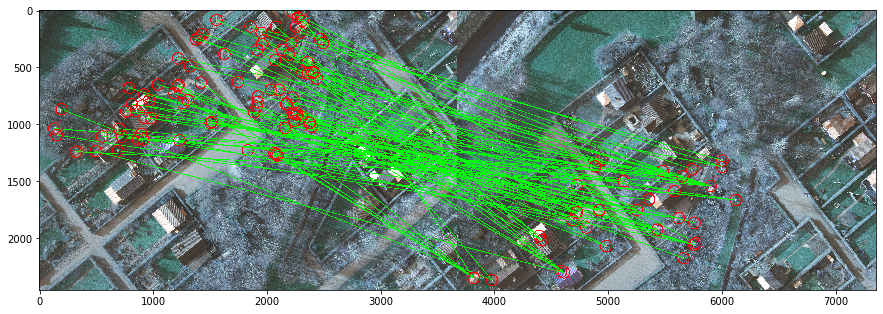

In [15]:
# Show One to More AtoB results(for report)
combined_img = stitch_imgs(img1_origin,img2_origin)
img_AtoB = draw_lines(combined_img, locations_A, locations_B)
plt.figure(figsize=(15, 7))
plt.imshow(img_AtoB,plt.cm.gray)
plt.show()

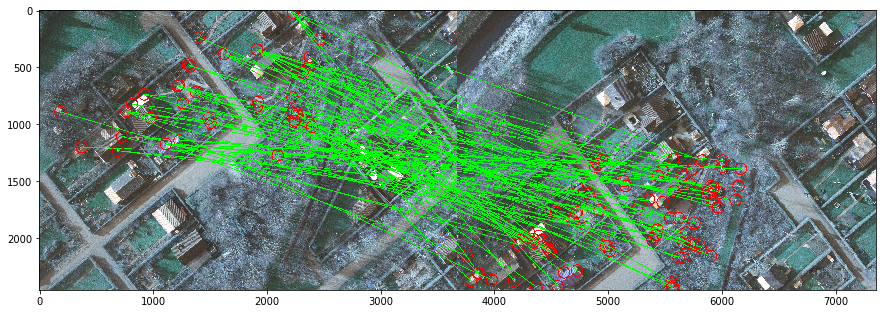

In [16]:
# Show One to More BtoA results(for report)
combined_img = stitch_imgs(img1_origin,img2_origin)
img_BtoA = draw_lines(combined_img, locations_2A, locations_2B)
plt.figure(figsize=(15, 7))
plt.imshow(img_BtoA,plt.cm.gray)
plt.show()

In [17]:
#--- hint2 ---#
match_locations1,match_locations2 = eliminateMultiCorrespondence(locations_A,locations_B,locations_2A,locations_2B)

total = ssdstat(match_AtoB)
print(len(total))
print("std",np.std(total))
print("mean",np.mean(total))

87
std 3.244924455790303
mean 35.22978093138698


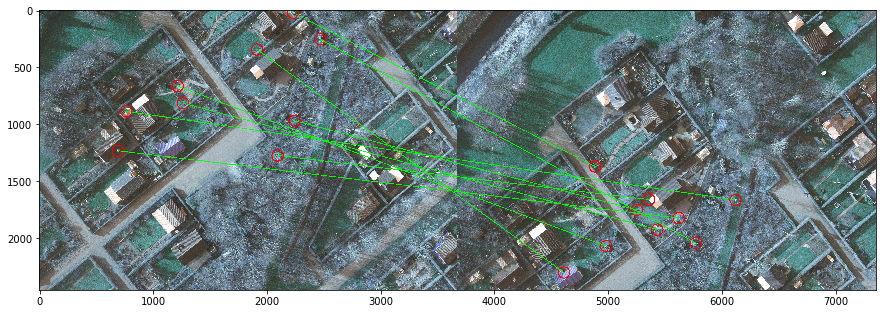

In [18]:
# match_locations1,match_locations2 = findLocations(match_final,patches1,locations_A,patches2,locations_B)
# match_locations2 = findLocations(match_final,patches2,new_corners2)
# print("match_locations",match_locations1,match_locations2)

combined_img = stitch_imgs(img1_origin,img2_origin)
plt.figure(figsize=(15, 7))
img4 = draw_lines(combined_img, match_locations1, match_locations2)
plt.imshow(img4,plt.cm.gray)
plt.show()
#============== 2.Feature matching ==============#


In [ ]:
#============== 3.Image stitching ==============#

